### Business Understanding

Mobile network operators continuously seek to improve user experience by ensuring reliable coverage and high-quality service. Drive testing is a standard practice for measuring real-world signal strength, quality, and network performance parameters across geographic areas. However, conducting drive tests is costly, time-consuming, and logistically complex.

The goal of this project is to develop a machine learning model that can predict key radio network KPIs — namely RSRP (Reference Signal Received Power), RSRQ (Reference Signal Received Quality), and SNR (Signal-to-Noise Ratio) — based on other measured parameters such as location, speed, and cell attributes.

Accurate prediction of these KPIs enables network planners and engineers to simulate and analyze network performance without needing extensive field measurements. This supports:

- Faster planning of new sites or upgrades

- Optimized network tuning and parameter adjustment

- Proactive identification of coverage or quality gaps

- Cost reduction in drive testing operations

By leveraging predictive modeling, mobile operators can make data-driven decisions to enhance coverage, capacity, and quality of service, directly improving end-user experience and competitive positioning.

# 📑 Data Dictionary: Drive Test Prediction Dataset

| Column Name             | Data Type   | Description                                                                                          |
|-------------------------|-------------|------------------------------------------------------------------------------------------------------|
| `Longitude`             | float       | GPS longitude of the measurement point.                                                              |
| `Latitude`              | float       | GPS latitude of the measurement point.                                                               |
| `Speed`                 | int         | Speed of the device (in km/h) at the time of measurement.                                            |
| `CellID`                | int         | Identifier of the serving cell tower (categorical feature).                                          |
| `RSRP`                  | int         | Reference Signal Received Power (in dBm), a key indicator of LTE signal strength. *(Prediction target)* |
| `RSRQ`                  | float       | Reference Signal Received Quality (in dB), reflects signal quality and interference. *(Prediction target)* |
| `SNR`                   | float       | Signal-to-Noise Ratio (in dB), measures signal clarity over background noise. *(Prediction target)*  |
| `CQI`                   | float       | Channel Quality Indicator reported by the device, used by the network for link adaptation.           |
| `RSSI`                  | float       | Received Signal Strength Indicator (in dBm), includes noise and interference power.                  |
| `DL_bitrate`            | int         | Downlink bitrate (in kbps), data speed from network to device.                                       |
| `UL_bitrate`            | int         | Uplink bitrate (in kbps), data speed from device to network.                                         |
| `NRxRSRP`               | float       | Reference Signal Received Power from a neighboring 5G NR cell (in dBm).                              |
| `NRxRSRQ`               | float       | Reference Signal Received Quality from a neighboring 5G NR cell (in dB).                             |
| `ServingCell_Lon`       | float       | Longitude coordinate of the serving cell tower.                                                      |
| `ServingCell_Lat`       | float       | Latitude coordinate of the serving cell tower.                                                       |
| `ServingCell_Distance`  | float       | Distance between measurement location and the serving cell tower (in meters or km).                  |
| `target`                | object      | Device used for gathering data                                                                       |
| `encoded_target`        | int         | Encoded version of the target variable, useful for classification tasks.                             |


### Data Understanding

In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras import layers, models, callbacks


# Utility libraries
import warnings
warnings.filterwarnings(action="ignore")

print("import all libraries")

import all libraries


In [2]:
# Load the dataset
df = pd.read_csv("./data/dataset.csv")

# read first five rows
df.head()


,Longitude,Latitude,Speed,CellID,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,target,encoded_target
0,-8.466939,51.897914,46,2,-99,-14.0,-2.0,6.0,-82.0,1688,31,-100.0,-17.0,-8.464806,51.891945,679.67,bus,0
1,-8.466616,51.897283,30,2,-99,-14.0,-1.0,7.0,-78.0,1688,31,-100.0,-17.0,-8.464806,51.891945,606.41,bus,0
2,-8.466616,51.897283,30,2,-99,-14.0,-2.0,7.0,-78.0,1498,27,-100.0,-17.0,-8.464806,51.891945,606.41,bus,0
3,-8.466616,51.897283,30,2,-98,-15.0,-1.0,6.0,-81.0,1286,24,-103.0,-18.0,-8.464806,51.891945,606.41,bus,0
4,-8.466616,51.897283,30,2,-98,-15.0,-1.0,4.0,-91.0,548,20,-103.0,-18.0,-8.464806,51.891945,606.41,bus,0


In [3]:
# Load the last 5 rows
df.tail()

,Longitude,Latitude,Speed,CellID,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,target,encoded_target
166332,-8.491416,51.935038,76,1,-112,-11.0,2.0,2.0,-81.0,0,0,-106.0,-6.0,-8.500809,51.926312,1164.57,train,4
166333,-8.491416,51.935038,76,1,-105,-8.0,10.0,11.0,-88.0,11,0,-90.0,-19.0,-8.500809,51.926312,1164.57,train,4
166334,-8.491416,51.935038,76,1,-105,-8.0,10.0,12.0,-81.0,0,0,-90.0,-19.0,-8.500809,51.926312,1164.57,train,4
166335,-8.491416,51.935038,76,1,-101,-6.0,13.0,12.0,-81.0,0,0,-102.0,-8.0,-8.500809,51.926312,1164.57,train,4
166336,-8.491416,51.935038,76,1,-101,-6.0,13.0,2.0,-87.0,0,0,-102.0,-8.0,-8.500809,51.926312,1164.57,train,4


In [4]:
# check the shape of the dataset
df.shape

(166337, 18)

In [5]:
df.columns

Index(['Longitude', 'Latitude', 'Speed', 'CellID', 'RSRP', 'RSRQ', 'SNR',
       'CQI', 'RSSI', 'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
       'ServingCell_Lon', 'ServingCell_Lat', 'ServingCell_Distance', 'target',
       'encoded_target'],
      dtype='object')

In [6]:
# Read information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166337 entries, 0 to 166336
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Longitude             166337 non-null  float64
 1   Latitude              166337 non-null  float64
 2   Speed                 166337 non-null  int64  
 3   CellID                166337 non-null  int64  
 4   RSRP                  166337 non-null  int64  
 5   RSRQ                  166337 non-null  float64
 6   SNR                   166337 non-null  float64
 7   CQI                   166337 non-null  float64
 8   RSSI                  166337 non-null  float64
 9   DL_bitrate            166337 non-null  int64  
 10  UL_bitrate            166337 non-null  int64  
 11  NRxRSRP               166337 non-null  float64
 12  NRxRSRQ               166337 non-null  float64
 13  ServingCell_Lon       166337 non-null  float64
 14  ServingCell_Lat       166337 non-null  float64
 15  

In [7]:
# Perform descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Longitude,166337.0,-8.460098,0.386904,-9.589915,-8.505641,-8.489030,-8.461203,-6.295653
Latitude,166337.0,51.995072,0.275722,51.871394,51.893425,51.898446,51.930188,53.346380
Speed,166337.0,28.019587,35.878859,0.000000,0.000000,12.000000,44.000000,166.000000
CellID,166337.0,4134.856664,11620.227295,0.000000,2.000000,2.000000,8.000000,65353.000000
RSRP,166337.0,-91.483482,15.860697,-200.000000,-103.000000,-93.000000,-82.000000,-27.000000
RSRQ,166337.0,-9.724950,5.339664,-24.000000,-14.000000,-12.000000,-2.000000,7.000000
SNR,166337.0,5.256966,6.729561,-30.000000,2.000000,5.000000,7.000000,33.000000
CQI,166337.0,8.059957,2.524785,1.000000,7.000000,8.000000,9.000000,15.000000
RSSI,166337.0,-80.247846,8.909536,-94.000000,-85.000000,-81.000000,-78.000000,-36.000000
DL_bitrate,166337.0,11328.803231,14280.815674,0.000000,1755.000000,5927.000000,15456.000000,173016.000000


In [8]:
# check null values
df.isnull().sum()

Longitude               0
Latitude                0
Speed                   0
CellID                  0
RSRP                    0
RSRQ                    0
SNR                     0
CQI                     0
RSSI                    0
DL_bitrate              0
UL_bitrate              0
NRxRSRP                 0
NRxRSRQ                 0
ServingCell_Lon         0
ServingCell_Lat         0
ServingCell_Distance    0
target                  0
encoded_target          0
dtype: int64

In [9]:
# Investigate positive RSRQ values
positive_rsrq = df[df['RSRQ'] > 0]
# Display the first few rows with positive RSRQ values
positive_rsrq.shape

(22, 18)

In [10]:
# Drop the rows with positive RSRQ values
df = df[df['RSRQ'] <= 0]
# Check the shape of the dataset after dropping rows
df.shape

(166315, 18)

#### Univariate analysis

In [11]:
df.columns

Index(['Longitude', 'Latitude', 'Speed', 'CellID', 'RSRP', 'RSRQ', 'SNR',
       'CQI', 'RSSI', 'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
       'ServingCell_Lon', 'ServingCell_Lat', 'ServingCell_Distance', 'target',
       'encoded_target'],
      dtype='object')

In [12]:
first_batch_columns = ['Longitude', 'Latitude', 'Speed', 'CellID', 'RSRP', 'RSRQ', 'SNR',
       'CQI']

second_batch_columns = ['RSSI', 'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
       'ServingCell_Lon', 'ServingCell_Lat', 'ServingCell_Distance']

<Figure size 1500x1000 with 0 Axes>

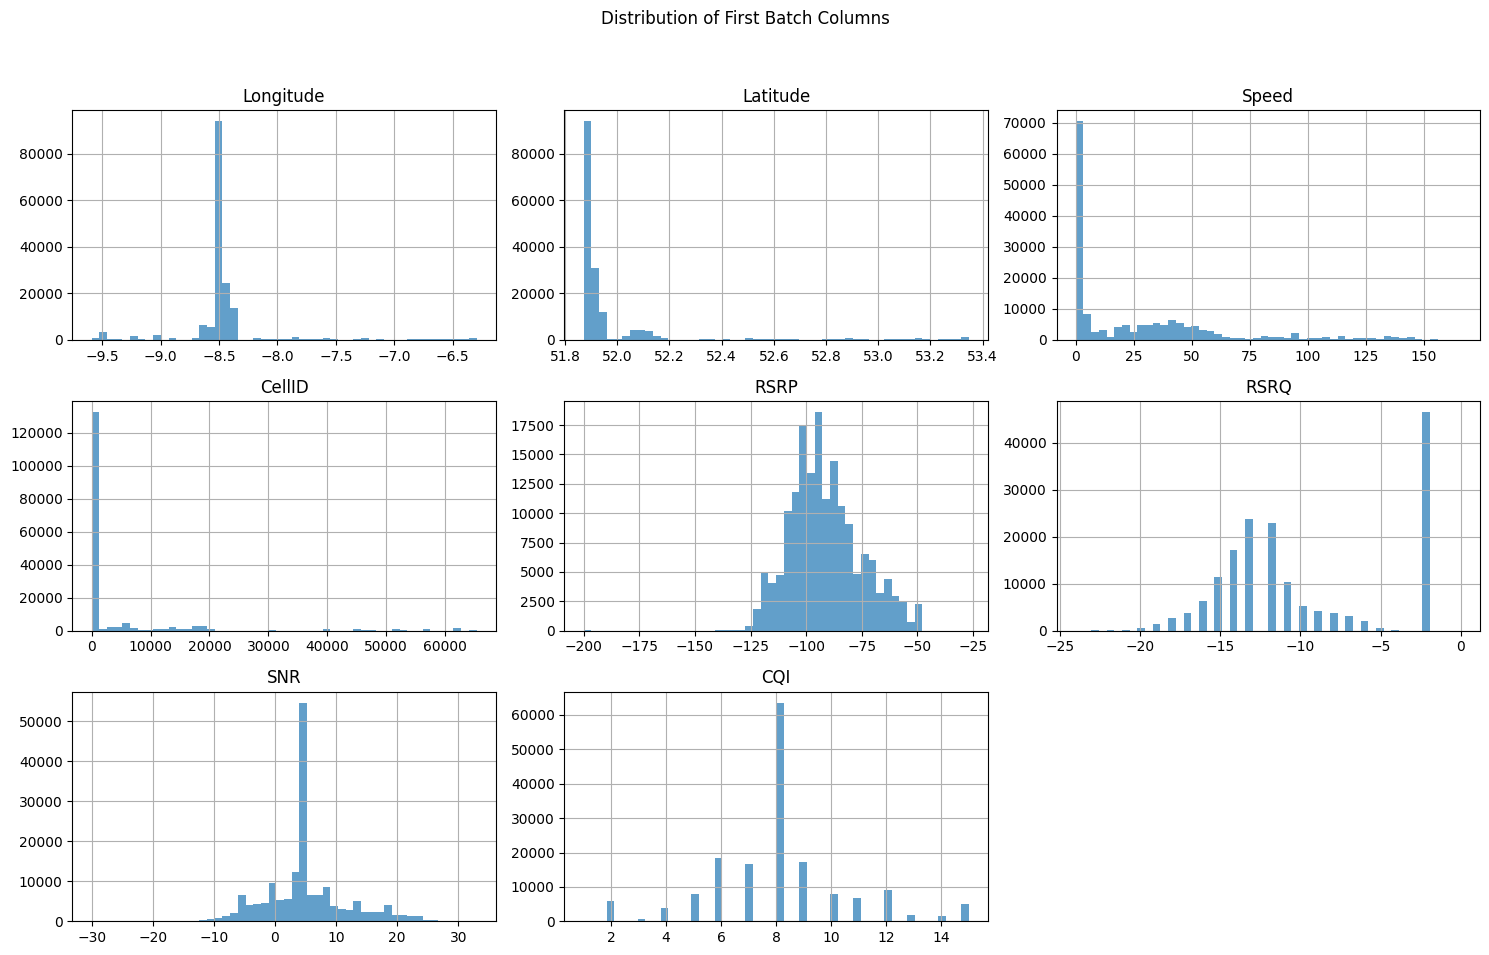

In [13]:
# Plotting the distribution of the first batch of columns
plt.figure(figsize=(15, 10))
df[first_batch_columns].hist(bins=50, figsize=(15, 10), layout=(3, 3), alpha=0.7)
plt.suptitle('Distribution of First Batch Columns') 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


<Figure size 1500x1000 with 0 Axes>

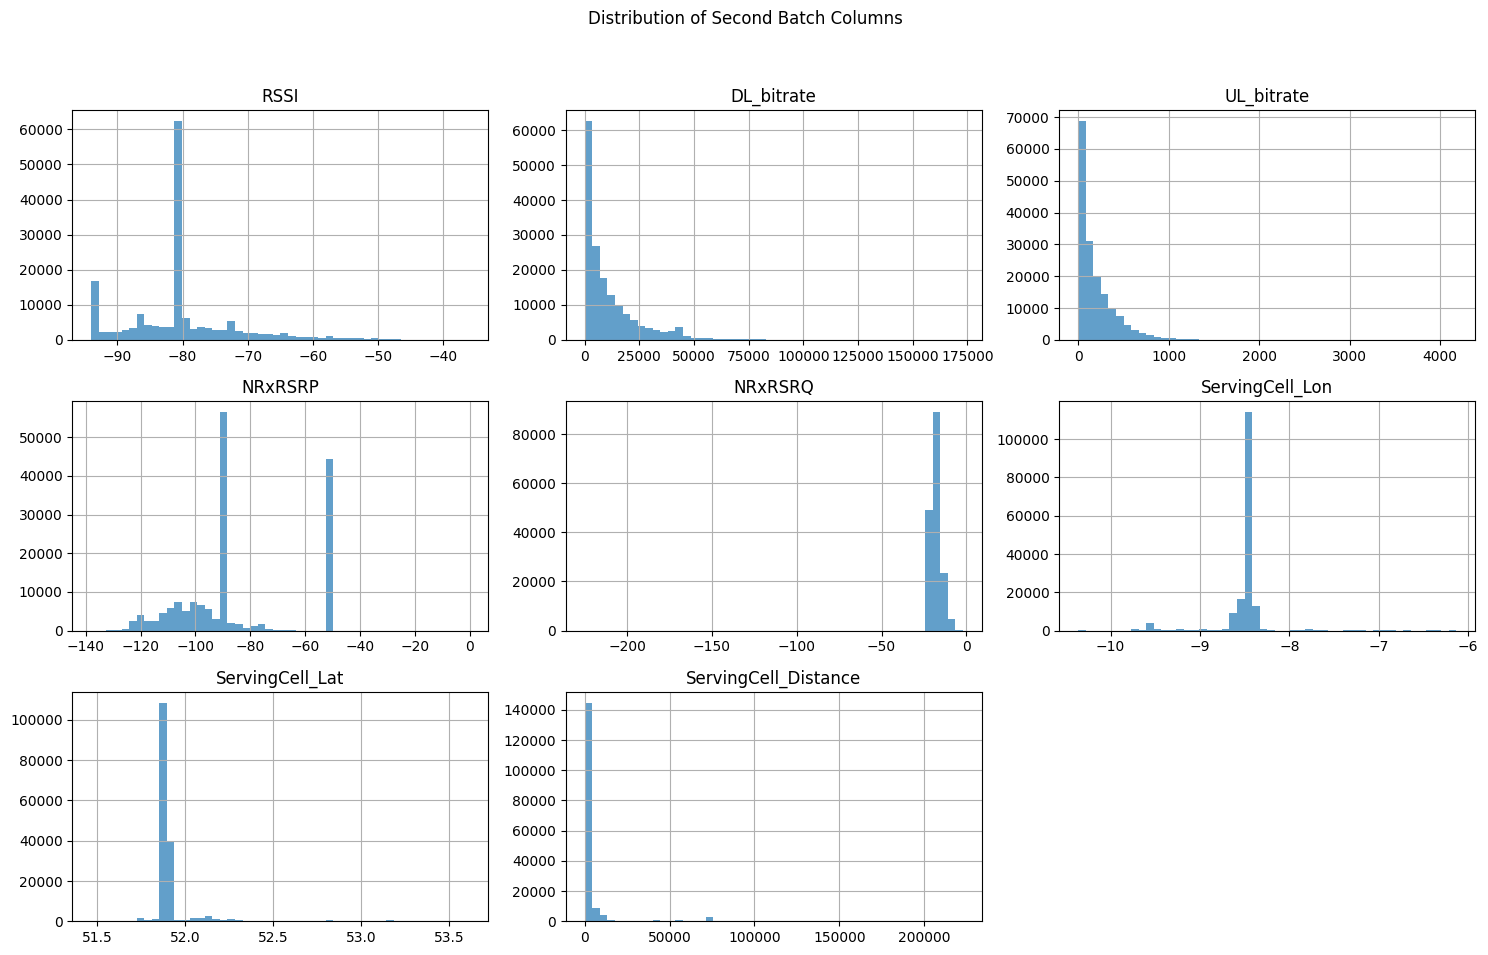

In [14]:
# Plotting the distribution of the second batch of columns
plt.figure(figsize=(15, 10))
df[second_batch_columns].hist(bins=50, figsize=(15, 10),
                                layout=(3, 3), alpha=0.7)
plt.suptitle('Distribution of Second Batch Columns')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


#### Check for outliers

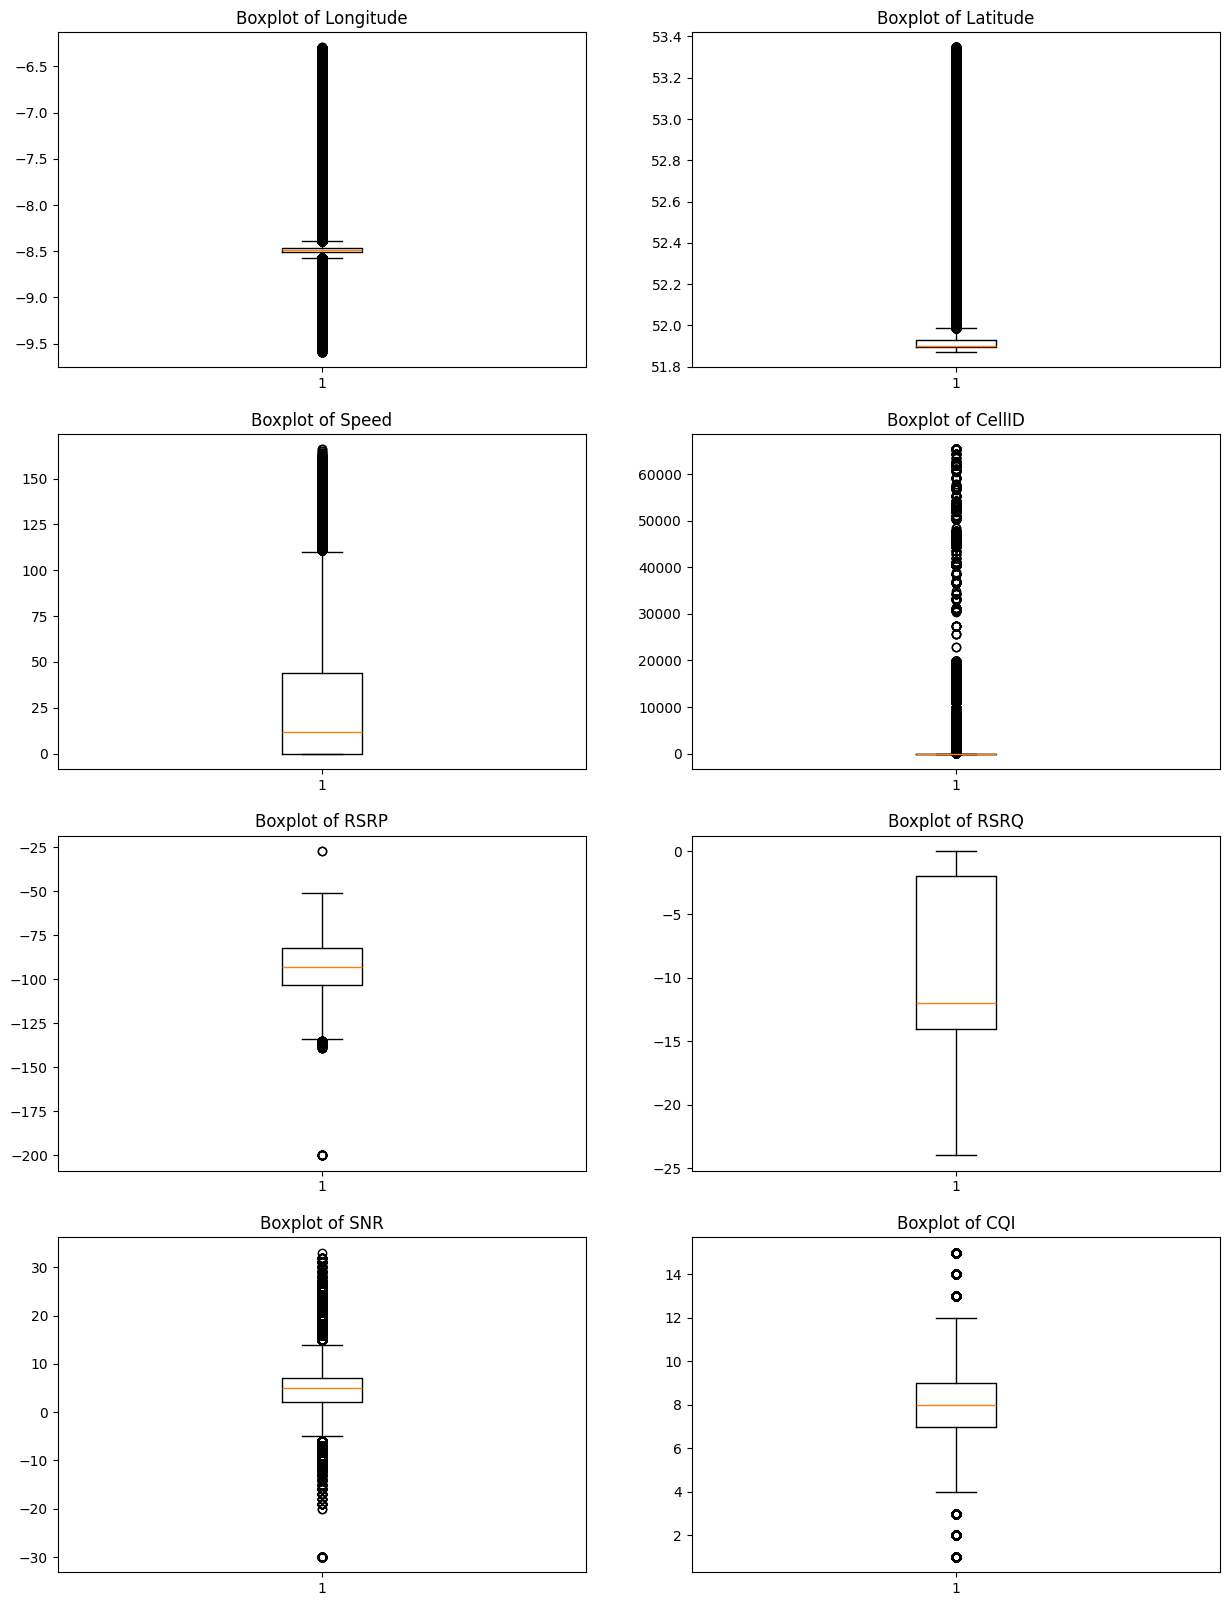

In [15]:

ncolumns = len(first_batch_columns)
nrows = (ncolumns + 1) // 2
plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
for i, column in enumerate(first_batch_columns):
    plt.subplot(nrows, 2, i + 1)
    plt.boxplot(df[column])
    plt.title(f'Boxplot of {column}')

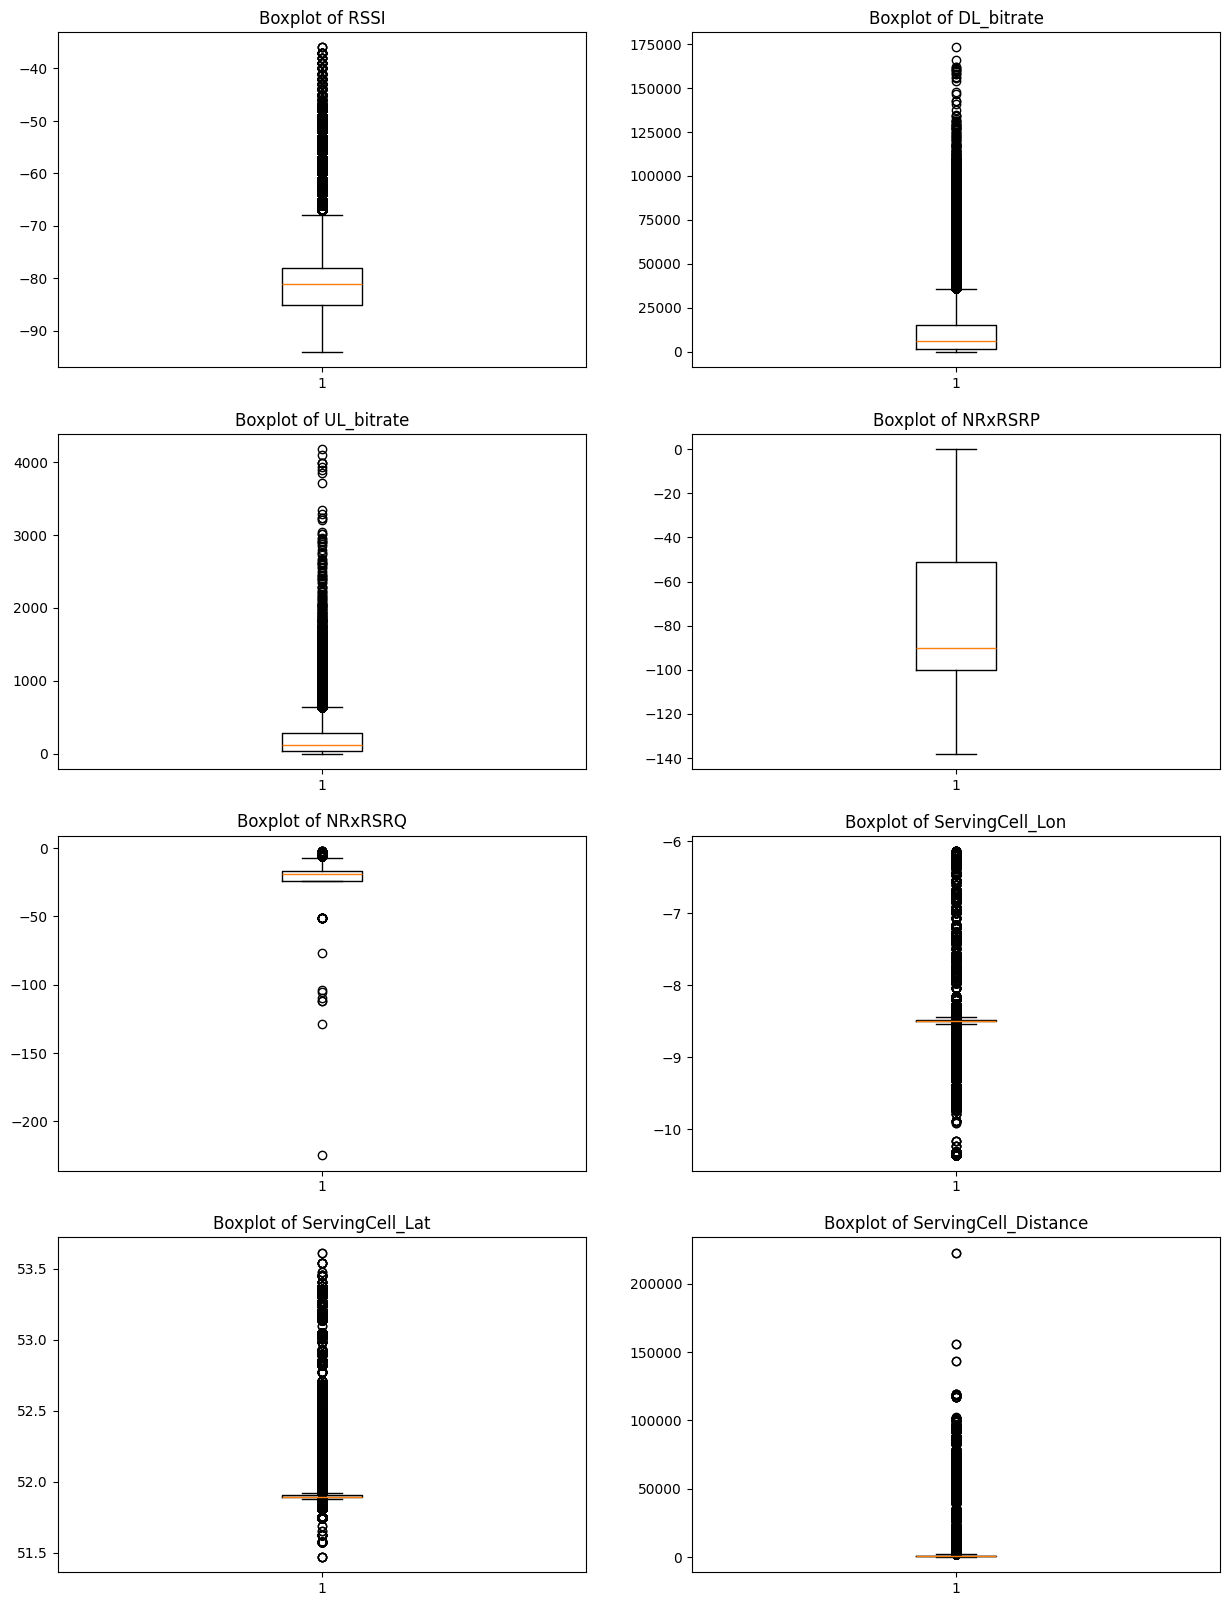

In [16]:
ncolumns = len(second_batch_columns)
nrows = (ncolumns + 1) // 2
plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
for i, column in enumerate(second_batch_columns):
    plt.subplot(nrows, 2, i + 1)
    plt.boxplot(df[column])
    plt.title(f'Boxplot of {column}')

#### Correlation Matrix

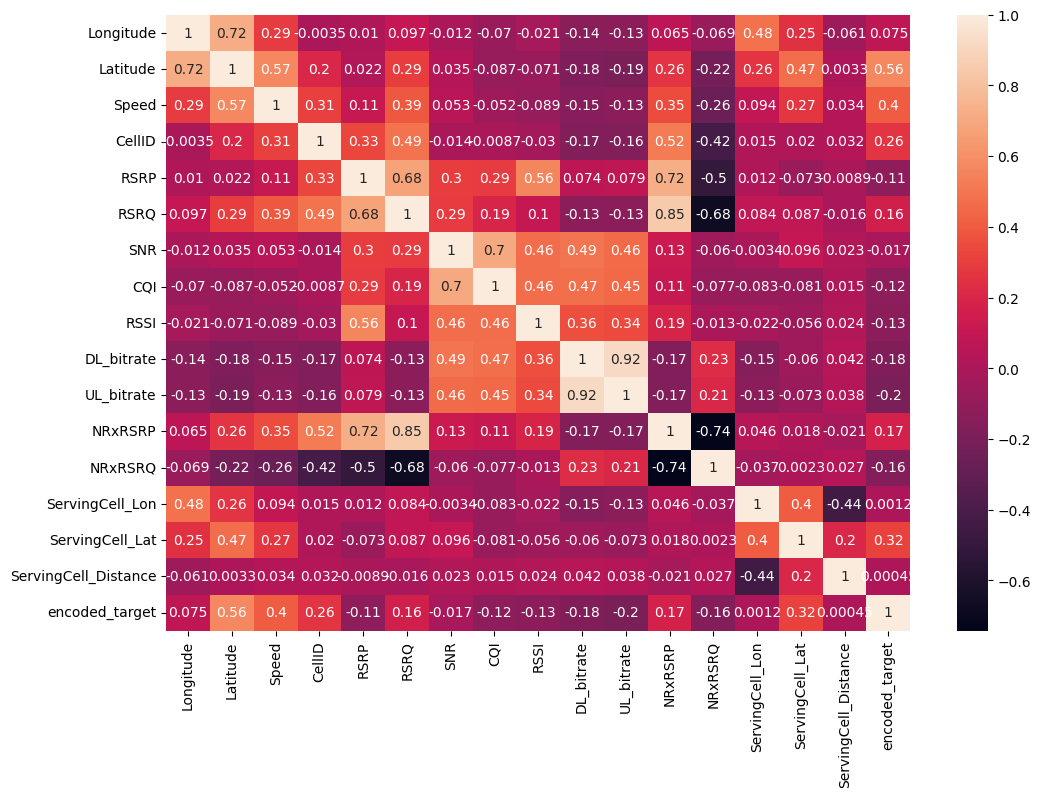

In [17]:
# Calculate th
corr_matrix = df.select_dtypes("number").corr()

# Visualize the corr_matrix with seaborn
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True)
plt.show()

#### Data Preparation

##### Train-Test Split

In [18]:
# Train-test split
df_train, df_test= train_test_split(df, test_size=0.3, random_state=42)

#### Split Data Into X and y


In [19]:
# Split data into X_train and y_train
X_train = df_train.drop(columns=['target','RSRP', 'RSRQ', 'SNR']) 
y_train = df_train[['RSRP', 'RSRQ', 'SNR']]


X_test = df_test.drop(columns=['target','RSRP', 'RSRQ', 'SNR']) 
y_test = df_test[['RSRP', 'RSRQ', 'SNR']]


#### Build ML Pipeline

#### Scale the features using RobustScaler
- RobustScaler is used to scale features by removing the median and scaling the data according to the
- Interquartile range, which is robust to outliers.
- This is particularly useful when the dataset contains outliers, as it reduces their influence on the  



In [20]:
# Separate scalers
X_scaler = RobustScaler()
y_scaler = RobustScaler()

# Fit on training data
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


#### Building The ML Model

In [21]:
# # instantiate the model
# multioutput_regressor = MultiOutputRegressor(SVR(kernel="rbf", C=100, gamma="scale"))


# # Fit the the model with the training data
# multioutput_regressor.fit(X_train_scaled,y_train_scaled)

In [22]:
# predicted_values = multioutput_regressor.predict(X_test_scaled)
# predicted_values

In [23]:
# # Inverse Transform
# inverse_predictions = y_scaler.inverse_transform(predicted_values)
# inverse_predictions

#### Evaluate the ML Model

In [24]:
# # Calculate the mean absolute error for my model
# mae = mean_absolute_error(y_test,inverse_predictions)

# # Calculate the mean squared error for my model
# mse = mean_squared_error(y_test,inverse_predictions)

# print("The mean absolute error of your model is: ", mae)
# print("The mean squared error of your model is: ", mse)


#### Fine-tune the ML Model

In [25]:
# # Example estimator
# base_model = SVR(kernel="rbf")

# # Multi-output wrapper
# model = MultiOutputRegressor(base_model)

# # Hyperparameter grid
# param_grid = {
#     'estimator__C': [0.1, 1, 10, 100],
#     'estimator__gamma': ['scale', 'auto', 0.01, 0.001],
#     'estimator__epsilon': [0.1, 0.2, 0.5]
# }

# # Randomized search
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=10,
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# # Fit search
# random_search.fit(X_train_scaled, y_train_scaled)

# # Best model
# best_model = random_search.best_estimator_

In [26]:
# Define model
def build_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(3)  # Output layer for RSRP, RSRQ, SNR
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse', 
        metrics=['mae']
    )
    
    return model


#### Training the Deep Learning Model

In [27]:
model = build_model(input_shape=X_train_scaled.shape[1])

# Optional: Early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.6115 - mae: 0.5351 - val_loss: 0.2795 - val_mae: 0.3263
Epoch 2/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.3277 - mae: 0.3623 - val_loss: 0.2458 - val_mae: 0.2958
Epoch 3/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.2971 - mae: 0.3404 - val_loss: 0.2260 - val_mae: 0.2803
Epoch 4/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 0.2843 - mae: 0.3312 - val_loss: 0.2287 - val_mae: 0.2774
Epoch 5/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.2736 - mae: 0.3230 - val_loss: 0.2149 - val_mae: 0.2664
Epoch 6/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.2649 - mae: 0.3172 - val_loss: 0.2073 - val_mae: 0.2618
Epoch 7/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - loss: 0.2608 - mae: 0.3153 - val_loss: 0.2077 - val_mae: 0.2626
Epoch 8/100
2911/2911 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.2603 - mae: 0.3131 - val_loss: 0.2025 - val_mae: 0.2603
Epoch 9/100
2911/2911 ━━

#### Get the Model's Architecture

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,099 (566.80 KB)

 Trainable params: 48,067 (187.76 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 96,136 (375.54 KB)

#### Evaluate the Model

In [29]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test MAE: {test_mae:.4f}")

# Predict and inverse scale if needed
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)  


1560/1560 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1646 - mae: 0.2270
Test MAE: 0.2262
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [30]:
y_pred

array([[ -72.469604 ,   -2.1247673,    5.080916 ],
       [ -74.8038   ,  -12.071484 ,    2.1507592],
       [ -99.01238  ,  -12.423783 ,    2.516101 ],
       ...,
       [ -77.89946  ,   -2.3715248,    5.107411 ],
       [ -98.29014  ,  -14.025864 ,   -0.679471 ],
       [-104.44985  ,  -12.331059 ,    3.1616764]], dtype=float32)

#### Visualize Loss Curve

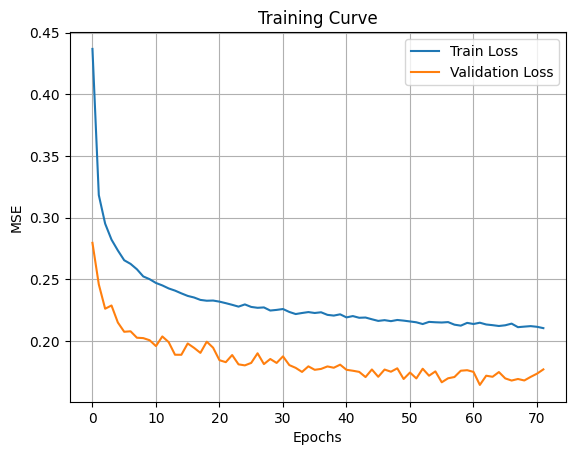

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Training Curve")
plt.grid(True)
plt.show()


#### Save the Deep Learning Model

In [32]:
model.save('drive_test_prediction.keras')